In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Fashion MNIST

In [2]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

#change data from images to tensors, then to torch.float32 and normalize
fashion_transform = Compose([
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

fashion = FashionMNIST(root='fashion', download=True, train=True, transform=fashion_transform)

fashion_names = ['T-shirt/top',
                 'Trouser',
                 'Pullover',
                 'Dress',
                 'Coat',
                 'Sandal',
                 'Shirt',
                 'Sneaker',
                 'Bag',
                 'Ankle boot']

# Visualize data

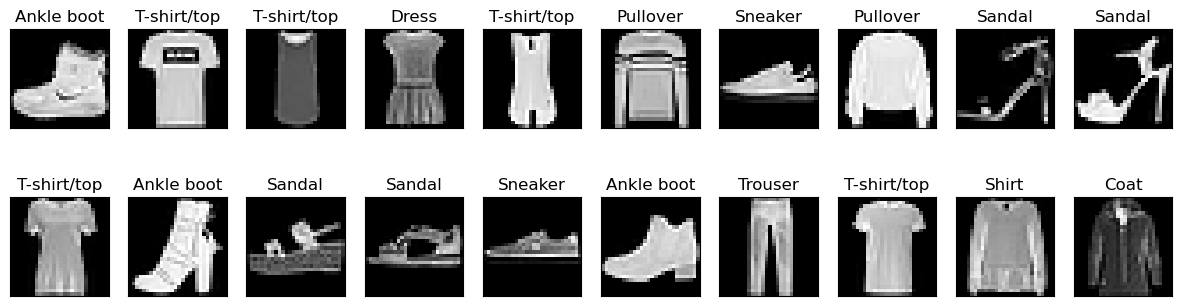

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))

for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(fashion[i][0].permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(fashion_names[fashion[i][1]])

plt.show()

In [4]:
from torch.utils.data import random_split
#split data into train and validation
train_set, valid_set = random_split(fashion, (0.95, 0.05))

In [5]:
fashion[0][0].shape

torch.Size([3, 28, 28])

## Simple network

In [59]:
# build model
from torch import nn
from torchsummary import summary

model = nn.Sequential(
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=2352, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
    nn.Sigmoid()
).to(device)

summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2352]               0
            Linear-2                  [-1, 512]       1,204,736
              ReLU-3                  [-1, 512]               0
            Linear-4                   [-1, 64]          32,832
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
           Sigmoid-7                   [-1, 10]               0
Total params: 1,238,218
Trainable params: 1,238,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 4.72
Estimated Total Size (MB): 4.76
----------------------------------------------------------------


In [60]:
# prepare data, optimizer and loss function

from torch.utils.data import DataLoader

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=8)
valid_loader = DataLoader(valid_set, batch_size=8)

## PyTorch Ignite

In [61]:
# create trainer and evaluators

from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

In [62]:
# add logging
from ignite.engine import Events


loss_hist = []
accuracy_hist = []
def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")
    loss_hist.append(engine.state.output)

    
trainer.add_event_handler(Events.ITERATION_COMPLETED(every=1000), log_iter_loss)

def compute_epoch_results(engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine, label=""):
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [63]:
# add lr scheduler

from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [64]:
# run training loop

trainer.run(train_loader, 2)

Epoch[1] - Iter[1000]: loss = 2.098146915435791
Epoch[1] - Iter[2000]: loss = 2.041313886642456
Epoch[1] - Iter[3000]: loss = 1.7871911525726318
Epoch[1] - Iter[4000]: loss = 1.8426591157913208
Epoch[1] - Iter[5000]: loss = 1.707062005996704
Epoch[1] - Iter[6000]: loss = 1.6650785207748413
Epoch[1] - Iter[7000]: loss = 1.6539435386657715
Train Res: accuracy = 0.7006315789473684, loss = 1.717828947368421
Valid Res: accuracy = 0.6966666666666667, loss = 1.72376953125
Optimizer learning rate = 0.001
Epoch[2] - Iter[8000]: loss = 1.6241415739059448
Epoch[2] - Iter[9000]: loss = 1.6400212049484253
Epoch[2] - Iter[10000]: loss = 1.6089296340942383
Epoch[2] - Iter[11000]: loss = 1.5567536354064941
Epoch[2] - Iter[12000]: loss = 1.7948603630065918
Epoch[2] - Iter[13000]: loss = 1.681179165840149
Epoch[2] - Iter[14000]: loss = 1.6437678337097168
Train Res: accuracy = 0.7107719298245614, loss = 1.6709961622807017
Valid Res: accuracy = 0.6986666666666667, loss = 1.6769422200520834
Optimizer learn

State:
	iteration: 14250
	epoch: 2
	epoch_length: 7125
	max_epochs: 2
	output: 1.7413312196731567
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

Text(0.5, 1.0, 'Loss')

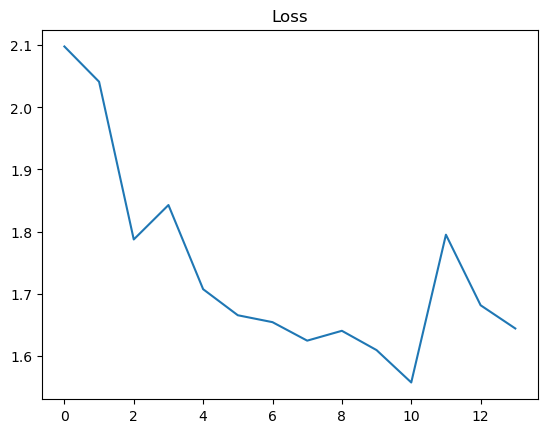

In [65]:

plt.plot(loss_hist)
plt.title("Loss")

Модель достигла accuracy 0.7 за одну эпоху и она почти не изменилась за вторую эпоху. Скорее всего добавление эпох не поможет улучшить результат.

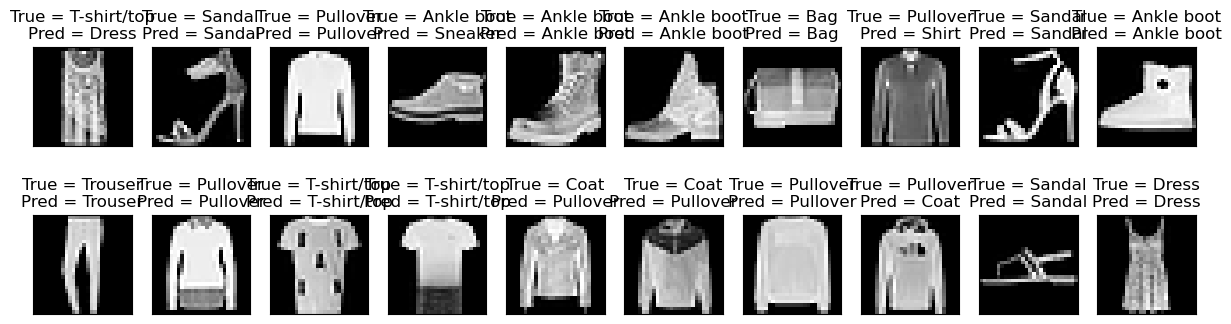

In [66]:
model.eval()

plt.figure(figsize=(15,4))

for i in range(20):
    x, y_true = valid_set[i]
    y_pred = torch.argmax(model(x.to(device)))
    plt.subplot(2, 10, i + 1)
    plt.imshow(x.permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {fashion_names[y_true]}\nPred = {fashion_names[y_pred]}')

plt.show()

## CNN, задача 2

In [94]:
model = nn.Sequential(

    nn.Conv2d(3, 16, 5),                
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # 
    nn.Conv2d(16, 64, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 256, 4),
    nn.ReLU(),

    nn.Flatten(-3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10)

).to(device)

summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]           1,216
              ReLU-2           [-1, 16, 24, 24]               0
         MaxPool2d-3           [-1, 16, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          25,664
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 256, 1, 1]         262,400
              ReLU-8            [-1, 256, 1, 1]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 306,378
Trainable params: 306,378
Non-trainable params: 0
-------------------------------

In [96]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_loader = DataLoader(train_set, batch_size=8)
valid_loader = DataLoader(valid_set, batch_size=8)

trainer = create_supervised_trainer(model, optimizer, criterion, device)

metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=1000), log_iter_loss)
trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)
train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train")
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid")

In [97]:
trainer.run(train_loader, 2)

Epoch[1] - Iter[1000]: loss = 0.9450267553329468
Epoch[1] - Iter[2000]: loss = 0.7323823571205139
Epoch[1] - Iter[3000]: loss = 0.21978208422660828
Epoch[1] - Iter[4000]: loss = 0.30510514974594116
Epoch[1] - Iter[5000]: loss = 0.3282720446586609
Epoch[1] - Iter[6000]: loss = 0.41626596450805664
Epoch[1] - Iter[7000]: loss = 0.2253127247095108
Train Res: accuracy = 0.8656491228070176, loss = 0.36222265625
Valid Res: accuracy = 0.8583333333333333, loss = 0.38749222819010415
Epoch[2] - Iter[8000]: loss = 0.34253573417663574
Epoch[2] - Iter[9000]: loss = 0.4126605987548828
Epoch[2] - Iter[10000]: loss = 0.281144917011261
Epoch[2] - Iter[11000]: loss = 0.0113820256665349
Epoch[2] - Iter[12000]: loss = 0.7731370329856873
Epoch[2] - Iter[13000]: loss = 0.13241809606552124
Epoch[2] - Iter[14000]: loss = 0.23206014931201935
Train Res: accuracy = 0.8891052631578947, loss = 0.3020257675438596
Valid Res: accuracy = 0.8783333333333333, loss = 0.341978271484375


State:
	iteration: 14250
	epoch: 2
	epoch_length: 7125
	max_epochs: 2
	output: 0.22509613633155823
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

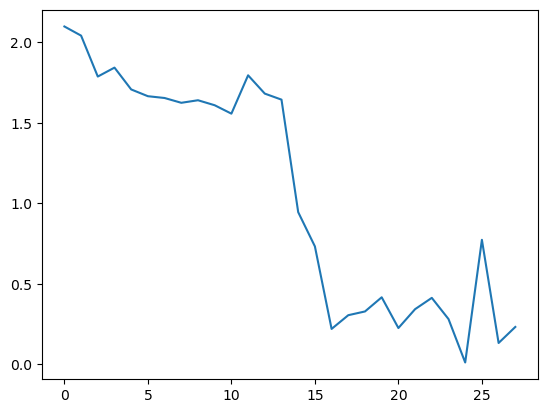

In [98]:
plt.plot(loss_hist)

Модель со свертками достигла accuracy >80% за одну эпоху и она почти не изменилась за вторую эпоху. Скорее всего, добавление эпох не поможет улучшить результат.
Заметим, что она ожидаемо работает лучше, чем модель без сверток.